In [88]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import nafot
from tqdm import tqdm, tqdm_notebook
import networkx as nx
from scipy import sparse
%matplotlib inline
gdf = nafot.gdf.copy()

### Load contact matrices

In [2]:
# Loading the contact matrices
contact_matrix = pd.read_csv('../data/matrix/contact_matrix_final_sample.csv')
contact_matrix_yeshuv = pd.read_csv('../data/matrix/contact_matrix_final_sample_yeshuv.csv')
contact_matrix_subdist = pd.read_csv('../data/matrix/contact_matrix_final_sample_subdist.csv')

# Setting index, dtype and replacing nan with 0
# Stat area contact matrix
contact_matrix.set_index(contact_matrix.columns[0], inplace=True)
contact_matrix.columns = contact_matrix.columns.astype(int)
contact_matrix.fillna(0, inplace=True)
# Yeshuv contact matrix
contact_matrix_yeshuv.set_index(contact_matrix_yeshuv.columns[0], inplace=True)
contact_matrix_yeshuv.columns = contact_matrix_yeshuv.columns.astype(int)
contact_matrix_yeshuv.fillna(0, inplace=True)
# Subdist contact matrix
contact_matrix_subdist.set_index(contact_matrix_subdist.columns[0], inplace=True)
contact_matrix_subdist.columns = contact_matrix_subdist.columns.astype(float)
contact_matrix_subdist.fillna(0, inplace=True)

In [3]:
# Get the population dictionary
pop_dict_subdist = nafot.get_population_dict('subdistrict')

# Calculate population proportion
total_pop = sum([pop_dict_subdist[area] for area in contact_matrix_subdist.index])
pop_prop_subdist_dict = {area: pop_dict_subdist[area]/total_pop for area in contact_matrix_subdist.index}
pop_prop_subdist = np.array([prop for prop in pop_prop_subdist_dict.values()])

### Calculating $n$ steps contact matrices $P^{(n)}$

In [4]:
# Clculate the n stesps from 1 to 100
Ps = [contact_matrix_subdist.values]
for n in tqdm_notebook(range(1,100)):
    Ps.append(np.dot(Ps[n-1], contact_matrix_subdist))

# Checking for convergence
for i in range(100-1):
    if np.all(Ps[i] - Ps[i+1] < 10**-7):
        convergence_step = i+1
        break

# Getting the relevant contact matrices (only until convergacne step)
Ps = Ps[:convergence_step]

# Save as a 3-dimentional array
Ps = np.array(Ps)

A Jupyter Widget

In [5]:
# # Clculate the n stesps from 1 to 100
# Ps = [(np.linalg.matrix_power(contact_matrix_subdist.values, n)) for n in tqdm_notebook(range(1,100+1))]

# # Checking for convergence
# for i in range(100-1):
#     if np.all(Ps[i] - Ps[i+1] < 10**-7):
#         convergence_step = i+1
#         break

# # Getting the relevant contact matrices (only until convergacne step)
# Ps = Ps[:convergence_step]

# # Save as a 3-dimentional array
# Ps1 = np.array(Ps)

### Calculating $f_{ij}^{(n)}$

In [5]:
Fs = np.zeros(Ps.shape)
Fs[0] = Ps[0].copy()

for n in tqdm_notebook(range(1, convergence_step)):
    for i in range(Fs.shape[1]):
        for j in range(Fs.shape[1]):
            Fs[n,i,j] = Ps[n,i,j] - np.sum([Fs[k,i,j]*Ps[n-k,j,j] for k in range(n)])

A Jupyter Widget

## Calculate the $Rank$
### $R_i=∑_j∑_n[p_j f_{ji}^{(n)} c^n ] $

In [6]:
infection_rate = 0.9999
def calculate_rank(Ps, Fs, pop_prop, convergence_step, infection_rate):
    rates_vector = np.array([infection_rate**n for n in range(1,convergence_step+1)])

    Rs = []
    for i in tqdm_notebook(range(contact_matrix_subdist.shape[0])):
        Rs.append((pop_prop_subdist*Fs[:,:,i]*rates_vector.reshape(convergence_step,1)).sum())

    # Save to an array
    Rs = np.array(Rs)

    # Normalize to a sum of one
    Rs = Rs/Rs.sum()
    
    return Rs

In [7]:
Rs = calculate_rank(Ps, Fs, pop_prop_subdist, convergence_step, infection_rate)

A Jupyter Widget

### Calculate $PageRank$

As the steady state

In [13]:
subdist_pageranks = Ps[-1][0]
subdist_pageranks

array([ 0.07038129,  0.18801065,  0.44116058,  0.04144823,  0.05650925,
        0.18349696,  0.01899304])

Usinig networkx

[0.07038058746641027,
 0.18802807385087736,
 0.44114763779152194,
 0.04144750743965316,
 0.056509100842312816,
 0.1834929141229031,
 0.018994178486321567]

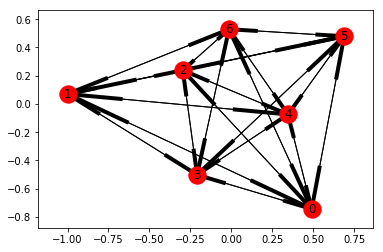

In [14]:
# G = nx.from_pandas_adjacency(contact_matrix_subdist, create_using=nx.DiGraph())
G = nx.from_numpy_matrix(contact_matrix_subdist.values, create_using=nx.DiGraph())

nx.drawing.nx_pylab.draw_networkx(G)

pagerank_dict = nx.pagerank(G, alpha=1)
subdist_pageranks_networkx = [pagerank_dict[i] for i in range(len(contact_matrix_subdist.index))]
subdist_pageranks_networkx

Comparison

In [15]:
subdist_pageranks - np.array(subdist_pageranks_networkx)

array([  7.03006276e-07,  -1.74287651e-05,   1.29410544e-05,
         7.23362512e-07,   1.48263045e-07,   4.04703367e-06,
        -1.13395488e-06])

In [16]:
# Save to a DataFrame
rank_df = pd.DataFrame(np.array(Rs), index=contact_matrix_subdist.index, columns=['Rank'])
rank_df.index.name='subdist_code'
rank_df['subdist_name'] = [nafot.subdistricts_names[i] for i in contact_matrix_subdist.index]
rank_df['population_prop'] = pop_prop_subdist
rank_df['PageRank'] = subdist_pageranks
rank_df = rank_df[['subdist_name', 'population_prop', 'Rank', 'PageRank']]

# Sort
rank_df.sort_values(inplace=True, by='Rank', ascending=False)

rank_df

,subdist_name,population_prop,Rank,PageRank
subdist_code,,,,
51.0,Tel Aviv,0.297027,0.158168,0.441161
42.0,Petah Tikva,0.141128,0.157899,0.183497
43.0,Ramla,0.065337,0.152311,0.056509
11.0,Jerusalem,0.210972,0.151405,0.188011
44.0,Rehovot,0.115715,0.139721,0.041448
61.0,Ashkelon,0.106064,0.137106,0.070381
77.0,Judea & Samaria,0.063756,0.103390,0.018993


### Rank Comparison Plot

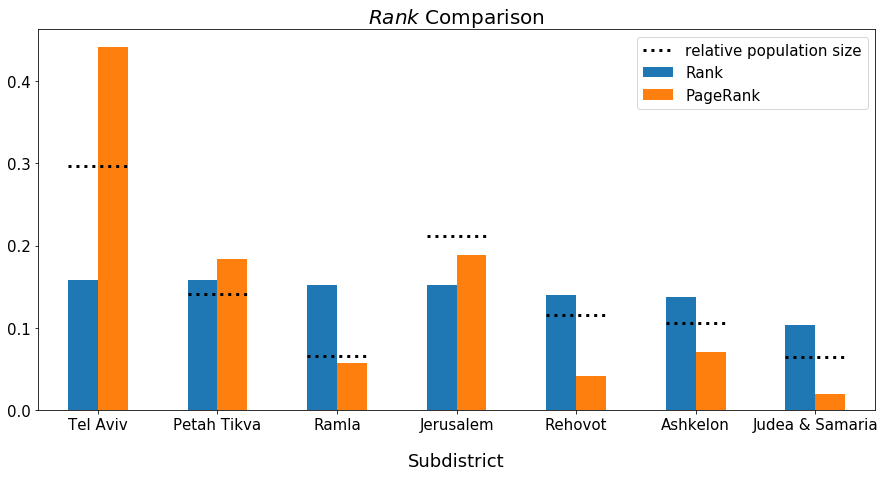

In [17]:
rank_df[['Rank', 'PageRank']].plot(kind='bar', figsize=(15,7), fontsize=15, use_index=False)
plt.title('$Rank$ Comparison', fontsize=20)
plt.xlabel('Subdistrict', fontsize=18, labelpad=20)
plt.xticks(np.arange(7), rank_df.subdist_name, rotation='horizontal')

# Plotting the dotted lines representing the relative population size using horizontal lines object
lines = plt.hlines(rank_df.population_prop, np.arange(7)-0.25,np.arange(7)+0.25, linestyles='dotted', color='black', **{'linewidth': 3},
           label='relative population size')

plt.legend(fontsize=15);

In [18]:
infection_rates = [0.001, 0.1, 0.5, 0.9, 0.99, 0.999, 1]
rank_values = np.array([1]*contact_matrix_subdist.shape[0])
for infection_rate in infection_rates:
    ranks = calculate_rank(Ps, Fs, pop_prop_subdist, convergence_step, infection_rate)
    rank_values = np.vstack([rank_values, ranks])
rank_values = rank_values[1:]

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

In [19]:
# Save to a DataFrame
rates_str = [str(rate) for rate in infection_rates]
ranks_df = pd.DataFrame(rank_values.T, columns=rates_str,
                        index=[nafot.subdistricts_names[i] for i in contact_matrix_subdist.index])
ranks_df.index.name='subdist_name'
ranks_df['subdist_code'] = contact_matrix_subdist.index
ranks_df['population_prop'] = pop_prop_subdist
ranks_df['PageRank'] = subdist_pageranks
ranks_df = ranks_df[['subdist_code', 'population_prop', 'PageRank']+rates_str]

# Sort
ranks_df.sort_values(inplace=True, by='PageRank', ascending=False)

ranks_df

,subdist_code,population_prop,PageRank,0.001,0.1,0.5,0.9,0.99,0.999,1
subdist_name,,,,,,,,,,
Tel Aviv,51.0,0.297027,0.441161,0.333670,0.332172,0.322400,0.267860,0.178974,0.160191,0.157942
Jerusalem,11.0,0.210972,0.188011,0.219590,0.216580,0.199650,0.164374,0.152904,0.151552,0.151389
Petah Tikva,42.0,0.141128,0.183497,0.153382,0.155482,0.167953,0.193149,0.169484,0.159098,0.157764
Ashkelon,61.0,0.106064,0.070381,0.102944,0.102720,0.101087,0.102945,0.128613,0.136248,0.137202
Ramla,43.0,0.065337,0.056509,0.063214,0.065064,0.076739,0.116420,0.148379,0.151980,0.152347
Rehovot,44.0,0.115715,0.041448,0.084087,0.084544,0.086875,0.099422,0.130845,0.138839,0.139820
Judea & Samaria,77.0,0.063756,0.018993,0.043113,0.043439,0.045296,0.055830,0.090800,0.102093,0.103536


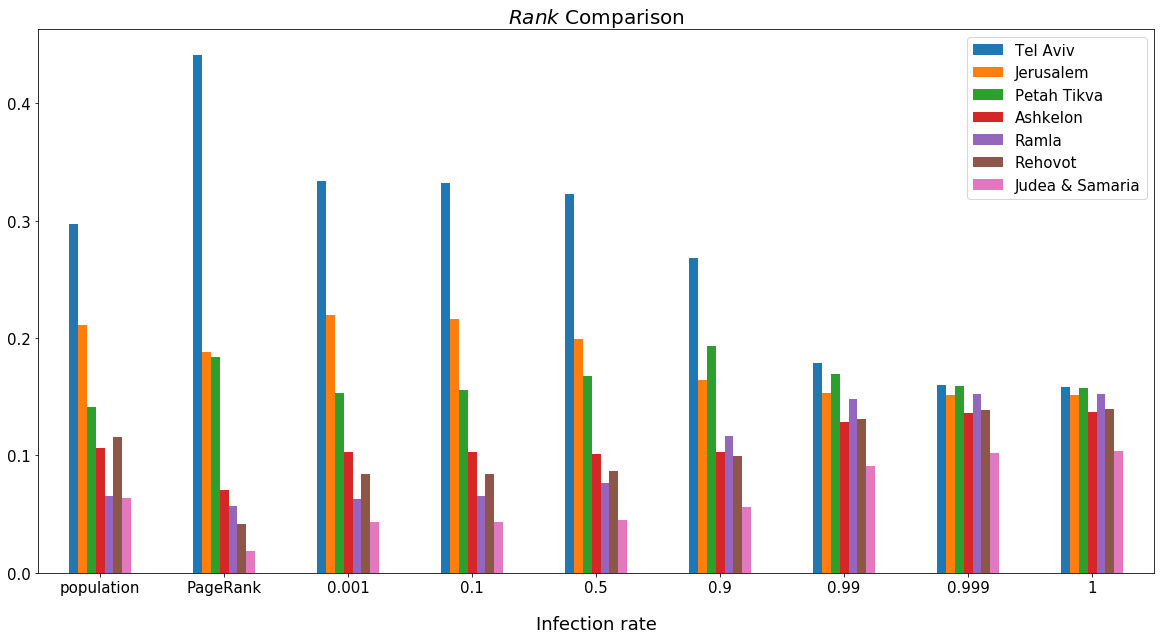

In [20]:
ranks_df[['population_prop', 'PageRank']+rates_str].T.plot(kind='bar', figsize=(20,10), fontsize=15, use_index=False)
plt.title('$Rank$ Comparison', fontsize=20)
plt.xlabel('Infection rate', fontsize=18, labelpad=20)
plt.xticks(np.arange(len(rates_str)+2), ['population','PageRank']+rates_str, rotation='horizontal')

plt.legend(fontsize=15);

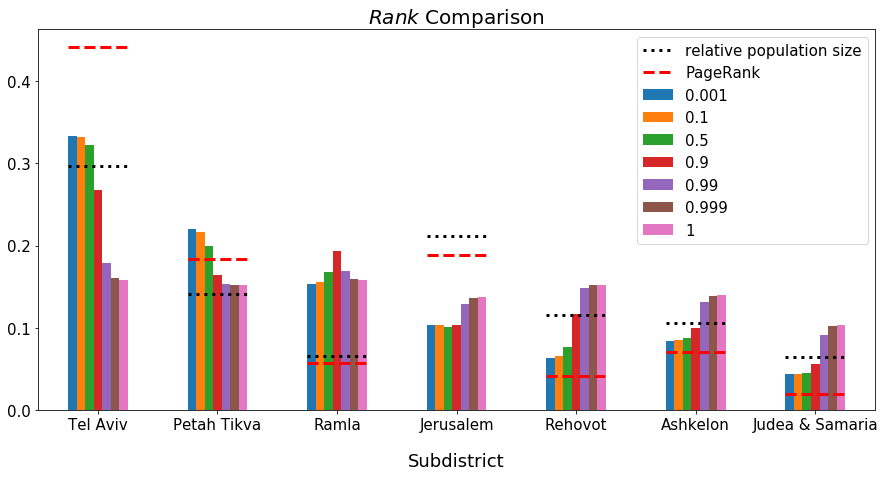

In [21]:
ranks_df[rates_str].plot(kind='bar', figsize=(15,7), fontsize=15, use_index=False)
plt.title('$Rank$ Comparison', fontsize=20)
plt.xlabel('Subdistrict', fontsize=18, labelpad=20)
plt.xticks(np.arange(7), rank_df.subdist_name, rotation='horizontal')

# Plotting the dotted lines representing the relative population size using horizontal lines object
lines = plt.hlines(rank_df.population_prop, np.arange(7)-0.25,np.arange(7)+0.25, linestyles='dotted', color='black', **{'linewidth': 3},
           label='relative population size')

lines2 = plt.hlines(rank_df.PageRank, np.arange(7)-0.25,np.arange(7)+0.25, linestyles='dashed', color='red', **{'linewidth': 3},
           label='PageRank')


plt.legend(fontsize=15);

# Generated Static Network

### Aggregating by area

In [22]:
# Read the network from gpickle
network = nx.read_gpickle("../../Data/network/static_network_10K.gpickle")

In [32]:
network.nodes[0]

{'area': 71, 'contact_dist': Unnamed: 0
 71         5
 3091       1
 6600427    1
 Name: 0, dtype: int32, 'contacts': 7, 'remaining_contact_dist': Series([], Name: 0, dtype: int32), 'remaining_contacts': 0, 'subdist': 61.0}

In [38]:
network[0]

AtlasView({452: {}, 8025.0: {}, 7986.0: {}, 3846.0: {}, 77.0: {}, 992.0: {}, 6918.0: {}})

In [34]:
adj = nx.to_numpy_array(network)

In [78]:
c = np.zeros(contact_matrix.shape)
for n in tqdm_notebook(network.nodes):
    node = network.nodes[n]
    node_area_idx = np.where(contact_matrix.index == node['area'])[0][0]
    
    # Go over the contacts
    for contact in network[n]:
        contact_node = network.nodes[contact]
        contat_area_idx = np.where(contact_matrix.index == contact_node['area'])[0][0]
        c[node_area_idx,contat_area_idx] += 1

c = c/2

A Jupyter Widget

In [96]:
c_df = pd.DataFrame(c, index=contact_matrix.index, columns=contact_matrix.index)

In [85]:
c_df_norm = c_df.apply(lambda row: row/row.sum() if row.sum()>0 else row, axis=1)

In [108]:
np.where(agg_area_id in c_df.index)

(array([], dtype=int64),)

In [112]:
hierarchical_list[agg_area_id][np.isin(hierarchical_list[agg_area_id], c_df.index)]

array([     71,     181,     241,     321,   70126,   70141,   70211,
         70231,   70232,   70233,   70241,   70242,   70243,   70312,
         70314,   70316,   70317,   70321,   70322,   70323,   70331,
         70332,   70333,   70411,   70412,   70421,   70422,   70426,
         70432,   70433,   70434,    1551,    1631,    2341,    2741,
          3091,    3151,    3201,    3361,    3401,    3581,    4001,
          4281,    5531,    5931,    6201,    6221,    6681,    6901,
          6921,    6991,    7001,    7271,    7391,    7461,    7561,
          7631,    7721,    7911,    7931,    8111,    8141,    8171,
          8181,    8191,    8211,    8241,    8271,    8451,    8881,
         10312,   10313,   10314,   10315,   10316,   10317,   10341,
         10342,   10343,   10344,   10345,   10346,   10981,   11491,
         12331,   12421,   14191,   20111,   20461,  263012,  263013,
        263014,  263015,  263021,  263022,  263023,  263024,  263025,
        263031,  263

In [113]:
# Get relevant level codes and names
area_level = 'subdistrict'
hierarchical_list = nafot.get_hierarchical_list(area_level)

# Get codes column names in gdf
code_col_names = {'district': 'DistrictCode', 'subdistrict': 'SubDistrictCode', 'yeshuv': 'SEMEL_YISH'}

if area_level != 'stat_area':
    # If the level is not stat area, add the relevant level to the location data
    area_col = code_col_names[area_level] 

# Get a list of the area's ids
areas_ids = pd.unique(gdf[area_col])

# Remove NaN
areas_ids = np.array(areas_ids[~np.isnan(areas_ids)])

# Aggregate the columns
matrix_A_agg_cols_df = pd.DataFrame(index=c_df.index, columns=areas_ids)
for agg_area_id in areas_ids:
    matrix_A_agg_cols_df[agg_area_id] = c_df[hierarchical_list[agg_area_id][np.isin(hierarchical_list[agg_area_id], c_df.index)]].sum(axis=1)

# Aggregate the rows
matrix_A_subdist_df = pd.DataFrame(index=areas_ids, columns=areas_ids)
for agg_area_id in areas_ids:
    matrix_A_subdist_df.loc[agg_area_id] = matrix_A_agg_cols_df.loc[hierarchical_list[agg_area_id][np.isin(hierarchical_list[agg_area_id], c_df.index)]].sum()

In [115]:
contact_matrix_subdist.index

Float64Index([61.0, 11.0, 51.0, 44.0, 43.0, 42.0, 77.0], dtype='float64', name='subdist_code')

In [119]:
matrix_A_subdist_df.loc[contact_matrix_subdist][contact_matrix_subdist.index]

ValueError: Cannot index with multidimensional key

### Calculating $n$ steps contact matrices $P^{(n)}$

In [4]:
# Clculate the n stesps from 1 to 100
Ps = [contact_matrix_subdist.values]
for n in tqdm_notebook(range(1,100)):
    Ps.append(np.dot(Ps[n-1], contact_matrix_subdist))

# Checking for convergence
for i in range(100-1):
    if np.all(Ps[i] - Ps[i+1] < 10**-7):
        convergence_step = i+1
        break

# Getting the relevant contact matrices (only until convergacne step)
Ps = Ps[:convergence_step]

# Save as a 3-dimentional array
Ps = np.array(Ps)

A Jupyter Widget

In [5]:
# # Clculate the n stesps from 1 to 100
# Ps = [(np.linalg.matrix_power(contact_matrix_subdist.values, n)) for n in tqdm_notebook(range(1,100+1))]

# # Checking for convergence
# for i in range(100-1):
#     if np.all(Ps[i] - Ps[i+1] < 10**-7):
#         convergence_step = i+1
#         break

# # Getting the relevant contact matrices (only until convergacne step)
# Ps = Ps[:convergence_step]

# # Save as a 3-dimentional array
# Ps1 = np.array(Ps)

### Calculating $f_{ij}^{(n)}$

In [5]:
Fs = np.zeros(Ps.shape)
Fs[0] = Ps[0].copy()

for n in tqdm_notebook(range(1, convergence_step)):
    for i in range(Fs.shape[1]):
        for j in range(Fs.shape[1]):
            Fs[n,i,j] = Ps[n,i,j] - np.sum([Fs[k,i,j]*Ps[n-k,j,j] for k in range(n)])

A Jupyter Widget

## Calculate the $Rank$
### $R_i=∑_j∑_n[p_j f_{ji}^{(n)} c^n ] $

In [6]:
infection_rate = 0.9999
def calculate_rank(Ps, Fs, pop_prop, convergence_step, infection_rate):
    rates_vector = np.array([infection_rate**n for n in range(1,convergence_step+1)])

    Rs = []
    for i in tqdm_notebook(range(contact_matrix_subdist.shape[0])):
        Rs.append((pop_prop_subdist*Fs[:,:,i]*rates_vector.reshape(convergence_step,1)).sum())

    # Save to an array
    Rs = np.array(Rs)

    # Normalize to a sum of one
    Rs = Rs/Rs.sum()
    
    return Rs

In [7]:
Rs = calculate_rank(Ps, Fs, pop_prop_subdist, convergence_step, infection_rate)

A Jupyter Widget

### Using Sparse Matrix

In [11]:
# Read the network from gpickle
network = nx.read_gpickle("../../Data/network/static_network_10K.gpickle")

In [12]:
# Get the adjacancy matrix (as sparse matrix)
sparse_adj_mat = nx.to_scipy_sparse_matrix(network)

### Calculating $n$ steps contact matrices $P^{(n)}$

In [18]:
# # Calculate the n stesps from 1 to 100
Ps_sparse = [sparse_adj_mat]
for n in tqdm_notebook(range(1,100)):
    Ps_sparse.append(Ps_sparse[n-1]*sparse_adj_mat)

# Convert to numpy array
Ps = [Ps_sparse[i].toarray() for i in tqdm_notebook(range(len(Ps_sparse)))] 

# Checking for convergence
for i in range(100-1):
    if np.all(Ps[i] - Ps[i+1] < 10**-7):
        convergence_step = i+1
        break

# Getting the relevant contact matrices (only until convergacne step)
Ps = Ps[:convergence_step]

# Save as a 3-dimentional array
Ps = np.array(Ps)

### Calculating $f_{ij}^{(n)}$

In [21]:
Fs = np.zeros(Ps.shape)
Fs[0] = Ps[0].copy()

for n in tqdm_notebook(range(1, convergence_step)):
    for i in range(Fs.shape[1]):
        for j in range(Fs.shape[1]):
            Fs[n,i,j] = Ps[n,i,j] - np.sum([Fs[k,i,j]*Ps[n-k,j,j] for k in range(n)])

  0%|                                                                                           | 0/89 [00:00<?, ?it/s]

KeyboardInterrupt: 

## Calculate the $Rank$
### $R_i=∑_j∑_n[p_j f_{ji}^{(n)} c^n ] $

In [6]:
infection_rate = 0.9999
def calculate_rank(Ps, Fs, pop_prop, convergence_step, infection_rate):
    rates_vector = np.array([infection_rate**n for n in range(1,convergence_step+1)])

    Rs = []
    for i in (range(contact_matrix_subdist.shape[0])):
        Rs.append((pop_prop_subdist*Fs[:,:,i]*rates_vector.reshape(convergence_step,1)).sum())

    # Save to an array
    Rs = np.array(Rs)

    # Normalize to a sum of one
    Rs = Rs/Rs.sum()
    
    return Rs

In [7]:
Rs = calculate_rank(Ps, Fs, pop_prop_subdist, convergence_step, infection_rate)

# OLD

In [62]:

Fs = [Ps[0]]

for n in (range(1, convergence_step)):
    f = np.zeros(contact_matrix_subdist.shape)
    for i in range(f.shape[0]):
        for j in range(f.shape[0]):
            f[i,j] = Ps[n,i,j] - np.sum([Fs[k][i,j]*Ps[n-k,j,j] for k in range(n)])
    Fs.append(f)

# Save to a 3-dimentional array
Fs = np.array(Fs)

190 ms ± 11 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [25]:
Fs = [Ps[0].values]

for n in tqdm(range(1, convergence_step)):
    f = np.zeros(contact_matrix_subdist.shape)
    for i in range(f.shape[0]):
        for j in range(f.shape[0]):
            f[i,j] = Ps[n].iloc[i,j] - np.sum([Fs[k][i,j]*Ps[n-k].iloc[j,j] for k in range(n)])
    Fs.append(f)

# Save to a 3-dimentional array
Fs = np.array(Fs)

AttributeError: 'numpy.ndarray' object has no attribute 'values'

## Calculate the index

In [200]:
%%timeit
infection_rate = 0.01
rates_vector = np.array([infection_rate**n for n in range(1,convergence_step+1)])

Rs = []
for i in (range(contact_matrix_subdist.shape[0])):
    R = 0
    for j in range(contact_matrix_subdist.shape[0]):
        for n in range(convergence_step):
            R += pop_prop_subdist[j]*Fs[n][j,i]*(infection_rate**(n+1))
    Rs.append(R)

6.89 ms ± 597 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [7]:
# infection rate
infection_rate = 0.05

# calculate the rate for every step n
rates_vector = np.array([infection_rate**n for n in range(1,100+1)])

# multiply the n-step transition probability matrix by the corresponding rate
updated_mat_steps = [mat_steps[n]*rates_vector[n] for n in range(100)]

# calculate the weighted sum of the matrices
sum_mat = updated_mat_steps[0].copy()
for cur_mat in updated_mat_steps[1:]:
    sum_mat += cur_mat 

 # Normalizing each row to a sum of 1
sum_mat_norm = sum_mat.values / sum_mat.sum(1).values.reshape((sum_mat.shape[0],1))
    
# calculate the steady state for the resulted matrix
sum_mat_ss = pd.DataFrame(np.linalg.matrix_power(sum_mat_norm, 100), columns=sum_mat.columns, index=sum_mat.index).iloc[0:1]

In [56]:
# infection rate
infection_rate = 0.05

# calculate the rate for every step n
rates_vector = np.array([infection_rate**n for n in range(1,100+1)])

# multiply the n-step transition probability matrix by the corresponding rate
updated_mat_steps = [mat_steps[n]*rates_vector[n] for n in range(100)]

# calculate the weighted sum of the matrices
sum_mat = updated_mat_steps[0].copy()
for cur_mat in updated_mat_steps[1:]:
    sum_mat += cur_mat 

 # Normalizing each row to a sum of 1
sum_mat_norm = sum_mat.values / sum_mat.sum(1).values.reshape((sum_mat.shape[0],1))
    
# calculate the steady state for the resulted matrix
sum_mat_ss = pd.DataFrame(np.linalg.matrix_power(sum_mat_norm, 100), columns=sum_mat.columns, index=sum_mat.index).iloc[0:1]